# Imports

In [6]:
import os
from pathlib import Path

In [1]:
import tensorflow as tf
import tensorflow_io as tfio

In [2]:
from IPython.display import Audio

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ipywidgets import interact

In [4]:
%load_ext autoreload 
%autoreload 2
%reload_ext autoreload

In [5]:
from birds.data.spectrogram import generate_tensor, generate_spectrogram
from birds.data.spectrogram import generate_mel_spectrogram, generate_db_scale_mel_spectrogram

# Tensorflow Dataset

## Import functions from `spectrogram.py`

In [20]:
directory = '../raw_data/data_30s/train/'
df = pd.read_csv(directory + 'y_train.csv')
df.head()

,Path,Target
0,Sonus-naturalis-447407_tens.ogg,0
1,Sonus-naturalis-387437_tens.ogg,0
2,Sonus-naturalis-383228_tens.ogg,0
3,Sonus-naturalis-358240_tens.ogg,0
4,Sonus-naturalis-397031_tens.ogg,0


In [25]:
file_paths = directory + df['Path'].values
labels = df['Target'].values
print(file_paths[50],labels[50])
generate_mel_spectrogram(file_paths[50],labels[50])

../raw_data/data_30s/train/Fringilla-coelebs-278566_tens.ogg 1


(<tf.Tensor: shape=(128, 625, 1), dtype=float32, numpy=
 array([[[0.00000000e+00],
         [0.00000000e+00],
         [2.45006726e-04],
         ...,
         [1.38877332e-01],
         [1.19903348e-02],
         [3.34953852e-02]],
 
        [[0.00000000e+00],
         [0.00000000e+00],
         [2.39668982e-04],
         ...,
         [1.27749830e-01],
         [8.14723130e-03],
         [3.77614051e-02]],
 
        [[0.00000000e+00],
         [0.00000000e+00],
         [2.25729775e-04],
         ...,
         [1.07779965e-01],
         [3.32684093e-03],
         [4.29967456e-02]],
 
        ...,
 
        [[0.00000000e+00],
         [0.00000000e+00],
         [6.36583063e-05],
         ...,
         [4.19081002e-03],
         [1.50359683e-02],
         [9.78403445e-03]],
 
        [[0.00000000e+00],
         [0.00000000e+00],
         [2.98568848e-05],
         ...,
         [2.57467804e-03],
         [6.53252425e-03],
         [6.15732791e-03]],
 
        [[0.00000000e+00],
       

In [48]:
ds_train = tf.data.Dataset.from_tensor_slices((file_paths, labels))

ds_train_mel = ds_train.map(generate_mel_spectrogram).batch(5)
ds_train_db_mel = ds_train.map(generate_db_scale_mel_spectrogram).batch(5)

In [27]:
spectrogram, label = next(iter(ds_train))

In [28]:
spectrogram.numpy().shape

(5, 128, 625, 1)

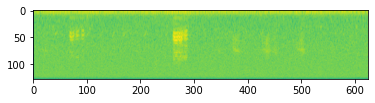

In [47]:
plt.imshow(tf.math.log(spectrogram.numpy()[3, :, :]));

# First model

In [49]:
ds_train = tf.data.Dataset.from_tensor_slices((file_paths, labels))
# Splitting the dataset for training and testing.
def is_test(x, _):
    return x % 4 == 0

def is_train(x, y):
    return not is_test(x, y)

recover = lambda x, y: y

# Split the dataset for training.
test_dataset = ds_train.enumerate() \
    .filter(is_test) \
    .map(recover)

# Split the dataset for testing/validation.
train_dataset = ds_train.enumerate() \
    .filter(is_train) \
    .map(recover)

In [50]:
from tensorflow.keras import models, layers, optimizers

In [51]:
model = models.Sequential()
model.add(layers.Conv2D(6, kernel_size=(3, 3), activation='relu', input_shape=(128, 625, 1)))
model.add(layers.Conv2D(4, kernel_size=(3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(50, activation='softmax')) 
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 126, 623, 6)       60        
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 124, 621, 4)       220       
_________________________________________________________________
flatten_3 (Flatten)          (None, 308016)            0         
_________________________________________________________________
dense_3 (Dense)              (None, 50)                15400850  
Total params: 15,401,130
Trainable params: 15,401,130
Non-trainable params: 0
_________________________________________________________________


In [52]:
opt = optimizers.Adam(learning_rate=0.01)
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

TypeError: 'BatchDataset' object is not subscriptable

In [42]:
from tensorflow.keras import callbacks
es = callbacks.EarlyStopping(patience=1, restore_best_weights=True)

history = model.fit(ds_train,
                    validation_split=0.3,
                    batch_size=16,
                    epochs=2,
                    callbacks=[es],
                    verbose=1)

ValueError: `validation_split` is only supported for Tensors or NumPy arrays, found following types in the input: [<class 'tensorflow.python.data.ops.dataset_ops.BatchDataset'>]